In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

In [121]:
cotton_price = 1.5
nitrogen_cost = 0.9
nitrogen_ratio = nitrogen_cost/cotton_price
sq_rate = 100
sq_yield = 1500
yield_sd = 100
eonr_sd = 25
rst_b2g = -0.02
opt_pcts = [50, 75, 100]
rate_rngs = [25, 50, 100]

In [122]:
trial = np.load('../data/Trial_Design.npy')
trial_names = np.load('../data/Trial_Design_names.npy', allow_pickle=True)
trial_idx = [i for i, n in enumerate(trial_names) if not 'rep' in n]
trial_coords = np.load('../data/Trial_Design_coords.npy')
trial_coords_idx = np.int0(np.floor(trial_coords/3))
n = trial_coords.shape[0]

rst_sim = np.load('../data/Trial_sim.npy')
b0_true = rst_sim[:100]
b1_true = rst_sim[100:]

meig = np.load('../data/Trial_meig.npy').transpose([-1, -2, -3])

In [147]:
idx = np.where(trial_names == 'size60_p100')[0][0]
opt_pct = 100
rate_rng = 25

rst_optr = sq_rate * (opt_pct/100 + (0.25 * b1_true))   
rst_optr = np.clip(rst_optr, 0, 200)

rst_b1 = -2 * rst_b2g * rst_optr + nitrogen_ratio
rst_b0 = sq_yield + yield_sd * b0_true
rst_b0 = rst_b0 - (rst_b1 * sq_rate + rst_b2g * sq_rate **2) 

rst_yield_ref =  rst_b0 + rst_b1 * sq_rate + rst_b2g * sq_rate**2
rst_yield_opt_f =  rst_b0 + rst_b1 * opt_pct + rst_b2g * opt_pct**2
rst_yield_opt =  rst_b0 + rst_b1 * rst_optr + rst_b2g * rst_optr**2

rst_net_ref = rst_yield_ref * cotton_price - sq_rate * nitrogen_cost
rst_net_opt_f = rst_yield_opt_f * cotton_price - opt_pct * nitrogen_cost 
rst_net_opt = rst_yield_opt * cotton_price - rst_optr * nitrogen_cost 

rst_net_f = (rst_net_opt_f - rst_net_ref).mean((1,2))
rst_net_max = (rst_net_opt - rst_net_ref).mean((1,2))
exp_name = trial_names[idx]
trial_rst = np.nan_to_num(trial[idx])/2

trial_rate = rate_rng * trial_rst
inp_rate = trial_rate + sq_rate
rst_yield_obs =  rst_b0 + rst_b1 * trial_rate + rst_b2g * trial_rate**2

X = trial_rate.reshape(1, -1)
Xf = (X ** np.array([0,1,2])[:,None]).T
y = rst_yield_obs.reshape(len(rst_yield_obs), -1).T
xpred, _, _, _ = np.linalg.lstsq(Xf, y, rcond = None)

b0_pred = xpred[0,:,None,None]
b1_pred = xpred[1,:,None,None]
b2_pred = xpred[2,:,None,None]
rst_optr_pred = np.clip((b1_pred - nitrogen_ratio) / (-2 * b2_pred),0, 200)

rst_yield_obs =  rst_b0 + rst_b1 * inp_rate + rst_b2g * inp_rate**2
rst_yield_pred =  rst_b0 + rst_b1 * rst_optr_pred + rst_b2g * rst_optr_pred**2

rst_net_obs = rst_yield_obs * cotton_price - inp_rate * nitrogen_cost 
rst_net_pred = rst_yield_pred * cotton_price - rst_optr_pred * nitrogen_cost 

rst_net_loss = (rst_net_obs - rst_net_ref).mean((1,2))
rst_net_diff = (rst_net_pred - rst_net_ref).mean((1,2))
rst_net_pct = 100 * rst_net_diff / rst_net_max.mean()
avg_nrate = rst_optr_pred.mean((1,2))

rnp = np.stack([rst_net_max, avg_nrate, rst_net_loss, rst_net_diff, rst_net_pct], -1)
df = pd.DataFrame(rnp, columns=['Max', 'AVG', 'Loss', 'VRT', 'VRTpct'])
df['rate_rng'] = rate_rng
df['opt_pct'] = opt_pct
df['Trial'] = exp_name
df['Rep'] = np.arange(len(df))

(array([   3029.,   44851.,  291882.,  940143., 1700633., 1738182.,
         959292.,  277820.,   40889.,    3279.]),
 array([ 2.5,  3.3,  4.1,  4.9,  5.7,  6.5,  7.3,  8.1,  8.9,  9.7, 10.5]),
 <BarContainer object of 10 artists>)

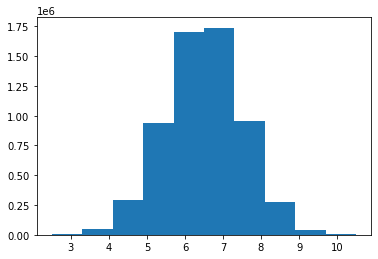

In [148]:
plt.hist(rst_b1.flatten())

(array([ 2.,  3., 11., 31., 25., 18.,  7.,  1.,  0.,  2.]),
 array([-0.16400107, -0.12821927, -0.09243747, -0.05665566, -0.02087386,
         0.01490794,  0.05068974,  0.08647155,  0.12225335,  0.15803515,
         0.19381695]),
 <BarContainer object of 10 artists>)

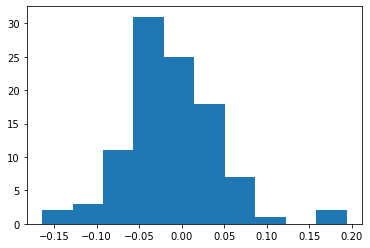

In [149]:
plt.hist(b2_pred.flatten())

In [150]:
df.AVG.mean(), df.AVG.std()

(38.06545778913784, 47.80454783178742)

<AxesSubplot:>

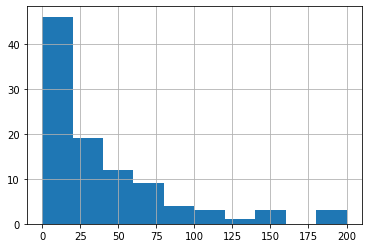

In [151]:
df.AVG.hist()

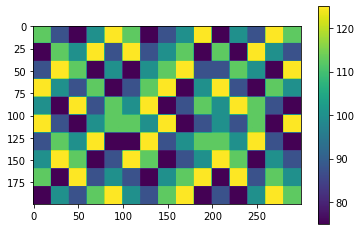

In [129]:
plt.imshow(inp_rate)
plt.colorbar()

In [130]:
df

,Max,AVG,Loss,VRT,VRTpct,rate_rng,opt_pct,Trial,Rep
0,4.999917,0.000000,-2.551714,-80.000000,-1600.075334,25,100,size60_p100,0
1,4.999917,0.000000,-2.503505,-80.000000,-1600.075334,25,100,size60_p100,1
2,4.999917,0.000000,-2.599702,-80.000000,-1600.075334,25,100,size60_p100,2
3,4.999780,57.852363,-2.861645,-14.211330,-284.239992,25,100,size60_p100,3
4,4.999917,47.941318,-2.706958,-21.680851,-433.637429,25,100,size60_p100,4
...,...,...,...,...,...,...,...,...,...
95,4.999917,0.000000,-2.306722,-80.000000,-1600.075334,25,100,size60_p100,95
96,4.999917,158.232227,-3.005317,-27.127939,-542.584316,25,100,size60_p100,96
97,4.998479,30.875703,-2.721255,-38.224409,-764.524169,25,100,size60_p100,97
98,4.995716,29.869702,-2.647532,-39.343213,-786.901300,25,100,size60_p100,98
